# Cryptocurrency Analysis

## Modules used in this assignment

In [141]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.neural_network import MLPClassifier as NeuralNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
labelencoder = LabelEncoder()

def two_scales(ax1, title, time, data1, data2, c1, c2):
    plt.title(str(title))
    ax2 = ax1.twinx()
    ax1.plot(time, data1, color=c1)
    ax2.plot(time, data2, color=c2)
    return ax1, ax2

## Bitcoin Analysis

### 1.  Random Forest Classifier

##### Predict whether price will increase or decrease tomorrow

85/15 Train/Test Split

We accurately predicted the next day's price movement with 85.10% accuracy.

preds   decreased  increased
actual                      
0             517         16
1              77         14


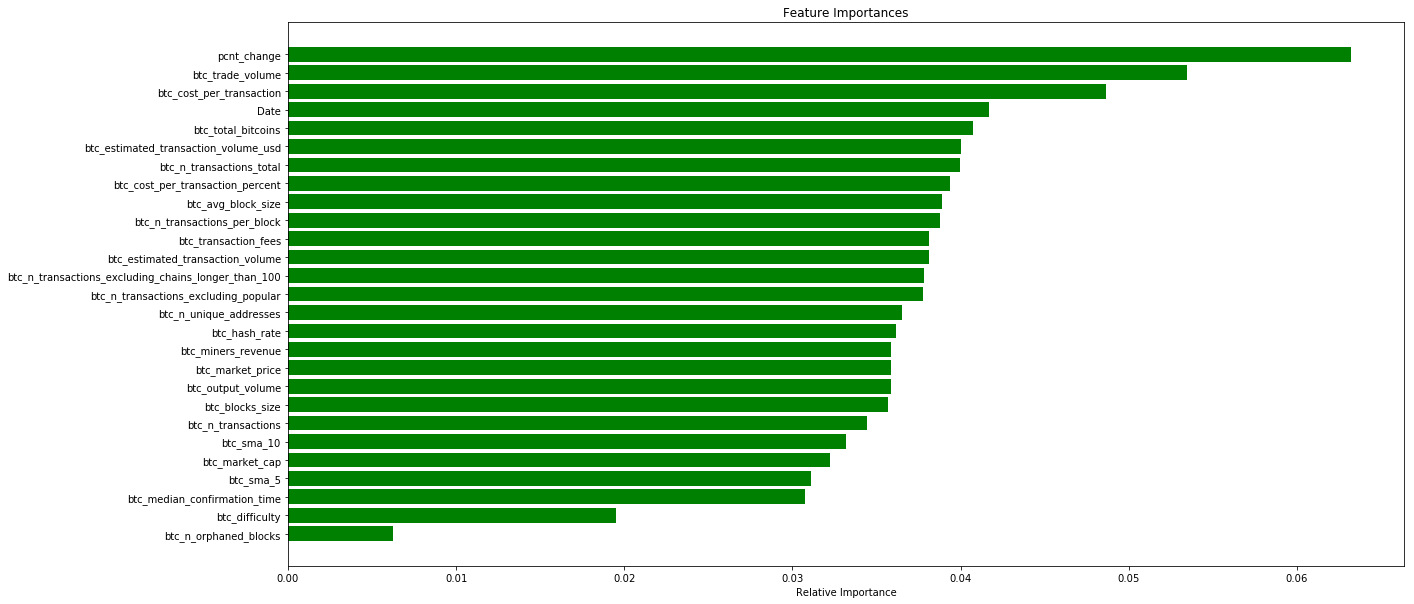

In [7]:
# load and format data
df = pd.read_csv('cryptocurrencypricehistory/bitcoin_dataset.csv').dropna()
outcomes = np.array(['decreased','increased'])
names = list(df.columns.values)

# preprocessing: factorize date column
for i in [0]:
    df.iloc[:,i] = labelencoder.fit_transform(df.iloc[:,i])
    
# train/test split
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .8
train, test = df[df['is_train']==True], df[df['is_train']==False]

# features (using all)
features = df.columns[0:27]

# random forest
forest = RFC(n_jobs=4,n_estimators=100)
forest.fit(train[features], train['2_drop_tomorrow'])

# predictions and plotting
preds = outcomes[forest.predict(test[features])]
accuracy = accuracy_score(test['2_drop_tomorrow'], forest.predict(test[features]), 
                          normalize=True, sample_weight=None) * 100
print("We accurately predicted the next day's price movement with %.2f%% accuracy.\n" % accuracy)
print pd.crosstab(index=test['2_drop_tomorrow'], columns=preds, 
                  rownames=['actual'], colnames=['preds'])
importances = forest.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], 
         color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

### Feature Selection

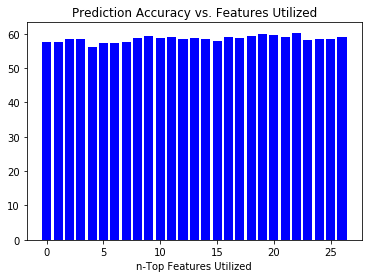

By using 23 of 27 features, we attained 60.29% accuracy



In [188]:
accuracy_l = []

for i in range(1,28):
    # how many?
    feats_to_keep = i

    # reduce features
    top_features = df.columns[indices[-1*int(feats_to_keep):]]

    # random forest
    forest = RFC(n_jobs=4,n_estimators=100)
    forest.fit(train[top_features], train['price_increases'])
    
    # predictions and plotting
    preds_with_split = forest.predict(test[top_features])
    preds = outcomes[preds_with_split]
    accuracy_l.append(accuracy_score(test['price_increases'], preds_with_split, 
                          normalize=True, sample_weight=None) * 100)

plt.title('Prediction Accuracy vs. Features Utilized')
plt.bar(range(27), accuracy_l, color='b', align='center')
#plt.xticks(range(27), range(1,28))
plt.xlabel('n-Top Features Utilized')
plt.show()

best_n = accuracy_l.index(max(accuracy_l))

print("By using %d of %d features, we attained %.2f%% accuracy\n" % (best_n + 1,27,accuracy_l[best_n]))

feats_to_keep = best_n

# reduce features
top_features = df.columns[indices[-1*int(feats_to_keep):]]

# random forest
forest = RFC(n_jobs=4,n_estimators=100)
forest.fit(train[top_features], train['price_increases'])
preds = forest.predict(test[top_features])

### Backtesting

#### Load Pretrained Model (or use model defined above)

In [17]:
# Optional:  Load a saved model
#forest_model_pkl = open("forest_20171014", 'rb')
#forest = pickle.load(forest_model_pkl)
#print "Loaded Random Forest model :: ", forest

80.4794520548


#### Trade Strategy Backtesting

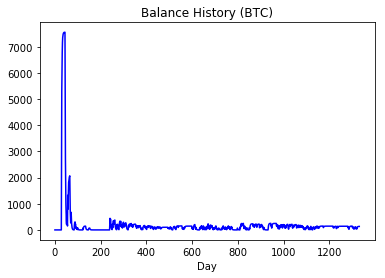

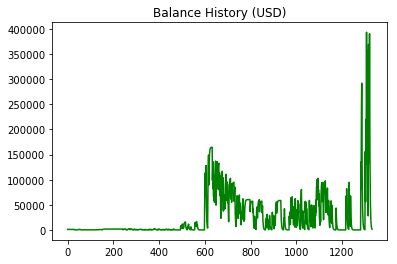

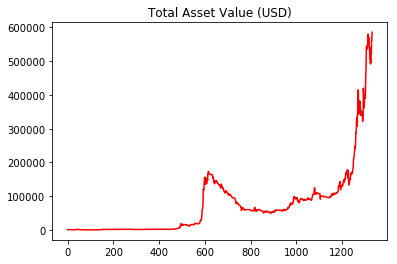

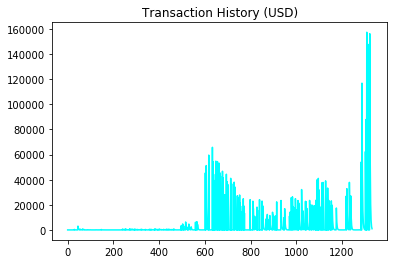

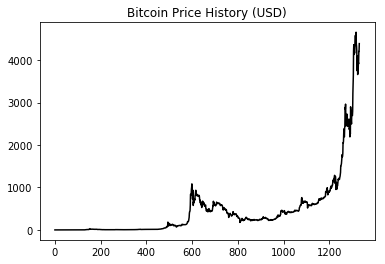

In [57]:
# edit here
#start = 2555
#end   = 2920
length = len(test)
testdays = list(test.index.values)
usd = 1000

# first non-zero row of CSV = 316 (index 315)
# last non-zero row of CSV = 2921 (index 2920)
# 1460 = 30 Sep 2013
# 1825 = 30 Sep 2014
# 2190 = 30 Sep 2015
# 2555 = 30 Sep 2016
# 2920 = 30 Sep 2017

# percent of current bitcoin to sell if price might decrease next day
pcnt_to_sell = 0.4

# percent of current USD to put towards BTC if the price dropped today and might increase tomorrow
pcnt_to_buy = 0.4

# start conditions
btc = 0
yesterday_btc_price = 0
btc_on_day = []
usd_on_day = []
asset_value = []
tx_history = []
btc_price_history = []
down_streak = []

for day in testdays:
    day = int(day)
    val = testdays.index(day)
    if day < 315:
        continue
    # values needed for calculation
    btc_price = float(df.iloc[day,1])
    tx_fee_pcnt = float(df.iloc[day,14])
    #tx_fee_pcnt = 2 # not sure how to set this
    prediction = preds[val]
    price_will_increase = prediction
    price_change = btc_price - yesterday_btc_price
    
    # if we predict bitcoin will drop tomorrow, sell
    if not(price_will_increase):
        
        # sell portion of bitcoin currently held
        tx = pcnt_to_sell * btc
        usd += (1 - tx_fee_pcnt/100.0) * (tx * btc_price)
        btc -= tx
        
    # if the price dropped today, buy more
    elif price_will_increase:
        
        # use portion of current usd to buy bitcoin
        tx = pcnt_to_buy * usd
        btc += (1 - tx_fee_pcnt/100.0) * (tx / btc_price)
        usd -= tx
        
    # save yesterday's price
    btc_on_day.append(btc)
    asset_value.append(usd + (btc*btc_price))
    usd_on_day.append(usd)
    tx_history.append(tx)
    btc_price_history.append(btc_price)
    yesterday_btc_price = btc_price
    
    
plt.title('Balance History (BTC)')
plt.plot(range(1332), btc_on_day, color='b')
plt.xlabel('Day')
plt.show()

plt.title('Balance History (USD)')
plt.plot(range(1332), usd_on_day, color='g')
plt.show()

plt.title('Total Asset Value (USD)')
plt.plot(range(1332), asset_value, color='r')
plt.show()

plt.title('Transaction History (USD)')
plt.plot(range(1332), tx_history, color='cyan')
plt.show()

plt.title('Bitcoin Price History (USD)')
plt.plot(range(1332), btc_price_history, color='k')
plt.show()

In [84]:
import pickle
forest_model_pkl = open("forest_20171014", 'wb')
pickle.dump(forest, forest_model_pkl)
forest_model_pkl.close()
print("Model successfully saved.")

# Loading the saved model using pickle
#forest_model_pkl = open("forest_20171014", 'rb')
#forest = pickle.load(forest_model_pkl)
#print "Loaded Random Forest model :: ", forest

Model successfully saved.


## Adaboost

AdaBoost Accuracy: 58.54%


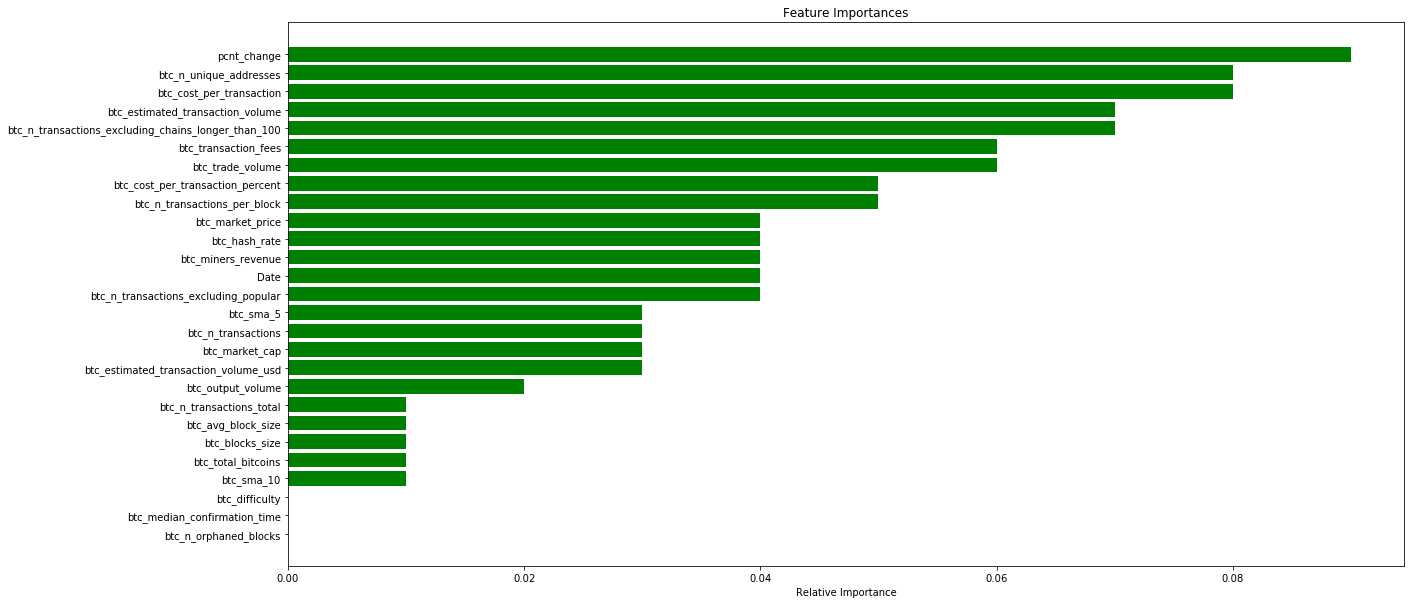

In [79]:
# dataset
df_ada = pd.read_csv('cryptocurrencypricehistory/bitcoin_dataset.csv')

# preprocessing: factorize date column
for i in [0]:
    df_ada.iloc[:,i] = labelencoder.fit_transform(df_ada.iloc[:,i])

# train/test split
df_ada['is_train'] = np.random.uniform(0, 1, len(df_ada)) <= .5
train, test = df_ada[df_ada['is_train']==True], df_ada[df_ada['is_train']==False]

# features (using all)
features = df_ada.columns[0:27]

# training and testing
adaboost = ABC(n_estimators=100).fit(train[features], train['price_increases'])
print("AdaBoost Accuracy: %.2f%%" % (adaboost.score(test[features], test['price_increases'])*100.0))

# feature importance
importances = adaboost.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], 
         color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

#### Feature Selection (AdaBoost)

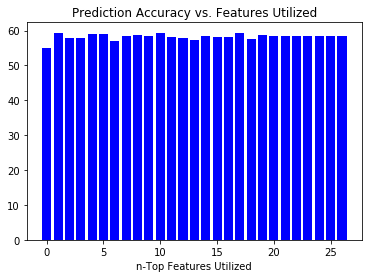

By using 18 of 27 features, we attained 59.38% accuracy



In [81]:
accuracy_l = []

for i in range(1,28):
    # how many?
    feats_to_keep = i

    # reduce features
    top_features = df_ada.columns[indices[-1*int(feats_to_keep):]]

    # adaboost
    adaboost = ABC(n_estimators=100).fit(train[features], train['price_increases'])
    adaboost.fit(train[top_features], train['price_increases'])
    
    # predictions and plotting
    accuracy_l.append(adaboost.score(test[top_features], test['price_increases']) * 100.0)

plt.title('Prediction Accuracy vs. Features Utilized')
plt.bar(range(27), accuracy_l, color='b', align='center')
plt.xlabel('n-Top Features Utilized')
plt.show()

best_n = accuracy_l.index(max(accuracy_l))

print("By using %d of %d features, we attained %.2f%% accuracy\n" % (best_n + 1,27,accuracy_l[best_n]))

## Gradient Boost

GradBoost Accuracy: 60.49%


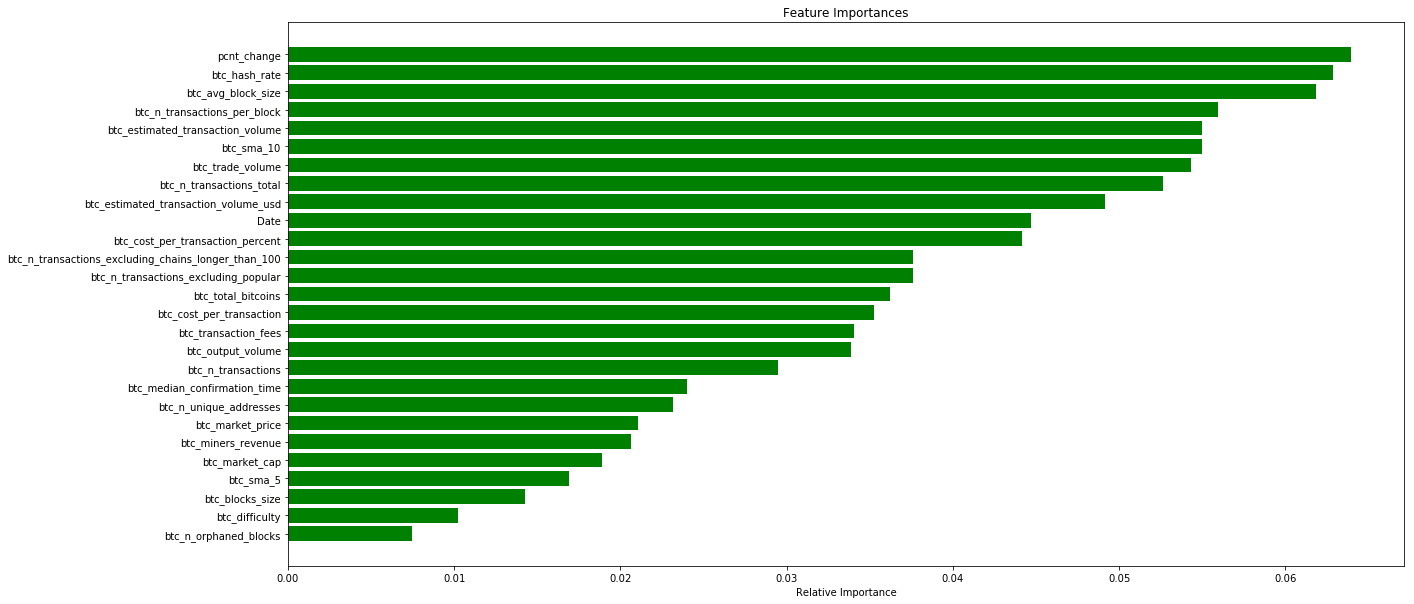

In [78]:
# dataset
df_gb = pd.read_csv('cryptocurrencypricehistory/bitcoin_dataset.csv')

# preprocessing: factorize date column
for i in [0]:
    df_gb.iloc[:,i] = labelencoder.fit_transform(df_gb.iloc[:,i])

# train/test split
df_gb['is_train'] = np.random.uniform(0, 1, len(df_gb)) <= .5
train, test = df_gb[df_gb['is_train']==True], df_gb[df_gb['is_train']==False]

# features (using all)
features = df_gb.columns[0:27]

# training and testing
gradboost = GBC(n_estimators=100, learning_rate=0.01, max_depth=10, random_state=5)
gradboost.fit(train[features], train['price_increases'])
print("GradBoost Accuracy: %.2f%%" % (gradboost.score(test[features], test['price_increases'])*100.0))

# feature importance
importances = gradboost.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], 
         color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

### Feature Selection (Gradient Boost)

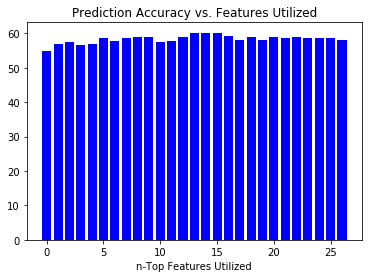

By using 14 of 27 features, we attained 60.21% accuracy



In [70]:
accuracy_l = []

for i in range(1,28):
    # how many?
    feats_to_keep = i
    # reduce features
    top_features = df_gb.columns[indices[-1*int(feats_to_keep):]]
    # gradient boost
    gradboost = GBC(n_estimators=100, learning_rate=0.01, max_depth=10, random_state=5)
    gradboost.fit(train[top_features], train['price_increases'])    
    # predictions and plotting
    accuracy_l.append(gradboost.score(test[top_features], test['price_increases']) * 100.0)

# plot feature selection results
plt.title('Prediction Accuracy vs. Features Utilized')
plt.bar(range(27), accuracy_l, color='b', align='center')
plt.xlabel('n-Top Features Utilized')
plt.show()
# optimal number of features
best_n = accuracy_l.index(max(accuracy_l))

print("By using %d of %d features, we attained %.2f%% accuracy\n" % (best_n + 1,27,accuracy_l[best_n]))

## Neural Network Classification

In [173]:
# dataset
df_nn = pd.read_csv('cryptocurrencypricehistory/bitcoin_dataset.csv')

# preprocessing: factorize date column
for i in [0]:
    df_nn.iloc[:,i] = labelencoder.fit_transform(df_nn.iloc[:,i])

# train/test split
df_nn['is_train'] = np.random.uniform(0, 1, len(df_nn)) <= .5
train, test = df_nn[df_nn['is_train']==True], df_nn[df_nn['is_train']==False]

# features (using all)
selective_features = range(1,27)
features = df_nn.columns[selective_features]

# transformations
scaler = StandardScaler()  
scaler.fit(train[features])  
train[features] = scaler.transform(train[features])  
test[features] = scaler.transform(test[features])  

# predict whether price will drop more than 5% tomorrow
nn = NeuralNet(solver='lbfgs', learning_rate_init=1e-3, alpha=1e-5, hidden_layer_sizes=(100,5), random_state=1, verbose=False)

# predict whether price will drop more than 5% tomorrow
nn.fit(train[features], train['5_drop_tomorrow'])
large_price_drop_prediction_5 = nn.predict(test[features])
probs_5_drop = nn.predict_proba(test[features])
print(nn.score(test[features], test['5_drop_tomorrow']))

# predict whether price will rise more than 5% tomorrow
nn.fit(train[features], train['5_gain_tomorrow'])
large_price_gain_prediction_5 = nn.predict(test[features])
probs_5_gain = nn.predict_proba(test[features])
print(nn.score(test[features], test['5_gain_tomorrow']))

# predict whether price will increase or decrease
nn.fit(train[features], train['price_increases'])
price_increases_tomorrow = nn.predict(test[features])
probs_inc = nn.predict_proba(test[features])
print(nn.score(test[features], test['price_increases']))

# predict whether price will rise more than 5% tomorrow
nn.fit(train[features], train['2_gain_tomorrow'])
large_price_gain_prediction_2 = nn.predict(test[features])
probs_2_gain = nn.predict_proba(test[features])
print(nn.score(test[features], test['2_gain_tomorrow']))

nn.fit(train[features], train['2_drop_tomorrow'])
large_price_drop_prediction_2 = nn.predict(test[features])
probs_2_drop = nn.predict_proba(test[features])
print(nn.score(test[features], test['2_drop_tomorrow']))

/Users/billyoung/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/billyoung/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.925155925156
0.869022869023
0.5841995842
0.727650727651
0.817740817741


#### Prediction w/ Neural Network

Bitcoin price gain: 7.32x
Our price gain: 4.23x


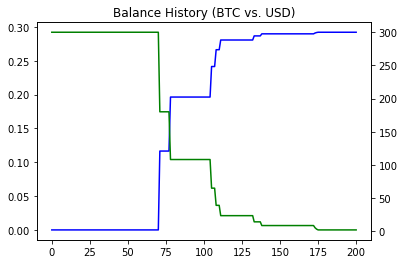

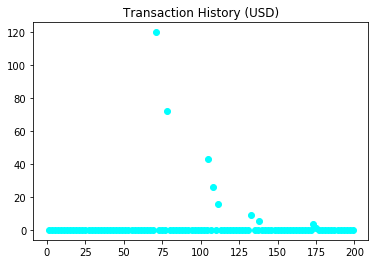

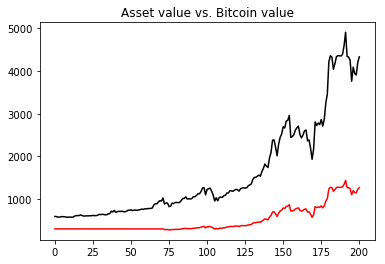

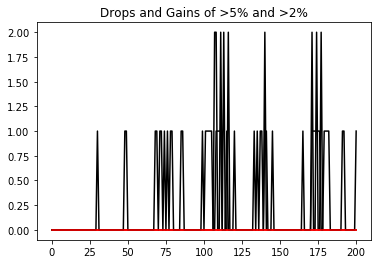

In [179]:
# start day
start = 2500
# percent of current bitcoin to sell if price might decrease next day
pcnt_to_sell = 0.8
# percent of current USD to put towards BTC if the price dropped today and might increase tomorrow
pcnt_to_buy = 0.8
# action threshold on prediction probabilities
th = 0.8

base = -1
i = 0
while base < 0 and testdays[i]<start:
    i += 1
    base = test.iloc[testdays[i],1]

# eliminate days without price information
length = len(test)
testdays = list(test.index.values)
for day in testdays:
    if day < start:
        length -= 1
        
# start conditions
usd = 300
btc = 0
btc_on_day = []
usd_on_day = []
asset_value = []
tx_history = []
btc_price_history = []
gains_5 = []
drops_5 = []
gains_2 = []
drops_2 = []

for day in testdays:
    if day < start:
        continue
    val = testdays.index(day)
    tx = 0
    # values needed for calculation
    btc_price = float(df_nn.iloc[day,1])
    tx_fee_pcnt = float(df_nn.iloc[day,14])
    price_large_drop_5 = large_price_drop_prediction_5[val]
    price_large_gain_5 = large_price_gain_prediction_5[val]
    price_large_drop_2 = large_price_drop_prediction_2[val]
    prob_2_drop = probs_2_drop[val]
    prob_2_gain = probs_2_gain[val]
    prob_5_drop = probs_5_drop[val]
    prob_5_gain = probs_5_gain[val]
    prob_inc = probs_inc[val]
    price_large_gain_2 = large_price_gain_prediction_2[val]
    price_will_increase = price_increases_tomorrow[val]
    
    # if we predict bitcoin will drop more than 5%, sell
    if price_large_drop_5 and prob_5_drop[1] > th and prob_5_gain[0] > th:
        # sell most bitcoin currently held
        tx = pcnt_to_sell * btc
        usd += (1 - tx_fee_pcnt/100.0) * (tx * btc_price)
        btc -= tx
    
    # if we predict bitcoin will rise more than 5%, buy
    elif price_large_gain_5 and prob_5_gain[1] > th and prob_5_drop[0] > th:
        # use most of current usd to buy bitcoin
        tx = pcnt_to_buy * usd
        btc += (1 - tx_fee_pcnt/100.0) * (tx / btc_price)
        usd -= tx
       
    elif price_large_drop_2 and prob_2_drop[1] > th+0.05 and prob_2_gain[0] > th+0.05:
        # sell most bitcoin currently held
        tx = 0.5 * pcnt_to_sell * btc
        usd += (1 - tx_fee_pcnt/100.0) * (tx * btc_price)
        btc -= tx
        
    elif price_large_gain_2 and prob_2_gain[1] > th+0.05 and prob_2_drop[0] > th+0.05:
        # use most of current usd to buy bitcoin
        tx = 0.5 * pcnt_to_buy * usd
        btc += (1 - tx_fee_pcnt/100.0) * (tx / btc_price)
        usd -= tx
    
    elif not(price_will_increase) and prob_inc[0] > 1:
        # sell a little bit of bitcoin
        tx = 0.1 * pcnt_to_sell * btc
        usd += (1 - tx_fee_pcnt/100.0) * (tx * btc_price)
        btc -= tx
    
    # save yesterday's price
    btc_on_day.append(btc)
    asset_value.append(usd + (btc*btc_price))
    usd_on_day.append(usd)
    tx_history.append(tx)
    btc_price_history.append(btc_price)
    gains_5.append(large_price_gain_prediction_5[val]*2)
    drops_5.append(large_price_drop_prediction_5[val]*2)
    gains_2.append(large_price_gain_prediction_2[val])
    drops_2.append(large_price_drop_prediction_2[val])

#print pd.crosstab(index=test['2_gain_tomorrow'], columns=large_price_gain_prediction_2)
    
print("Bitcoin price gain: %.2fx" % ((btc_price_history[-1])/btc_price_history[0]))
print("Our price gain: %.2fx" % ((asset_value[-1])/asset_value[0]))
    
# Create axes
fig, ax = plt.subplots()
ax1, ax2 = two_scales(ax,'Balance History (BTC vs. USD)', range(length), btc_on_day, usd_on_day, 'b', 'g')
plt.show()

plt.title('Transaction History (USD)')
dom = range(length)
for x in range(len(dom)-1):
    try:
        if tx_history[x] == 0:
            del tx_history[x]
            del dom[x]
    except:
        continue
plt.scatter(dom, tx_history, color='cyan')
plt.show()

plt.title('Asset value vs. Bitcoin value')
plt.plot(range(length), asset_value, color='r')
plt.plot(range(length), btc_price_history, color='k')
plt.show()

plt.title('Drops and Gains of >5% and >2%')
plt.plot(range(length), gains_5, color='k')
plt.plot(range(length), drops_5, color='r')
plt.plot(range(length), gains_2, color='k')
plt.plot(range(length), drops_2, color='r')
plt.show()

In [127]:
# Ground Truths

print(1-float(sum(df_nn.iloc[:,31]))/len(df_nn))
# 45.8% of the time, the price goes up the next day
# if we predit 0 every day, we'd get 54% accuracy

print(1-float(sum(df_nn.iloc[:,30]))/len(df_nn))
# 16.6% of the time, the price drops 2% the next day
# if we predict 0 every day, we'd get 83% accuracy

print(1-float(sum(df_nn.iloc[:,29]))/len(df_nn))
# 21% of the time, the price gains 2% the next day
# if we predict 0 every day, we'd get 79% accuracy

print(1-float(sum(df_nn.iloc[:,28]))/len(df_nn))
# 9.3% of the time, the price gains 5% the next day
# if we predict 0 every day, we'd get 90.7% accuracy

print(1-float(sum(df_nn.iloc[:,27]))/len(df_nn))
# 7.1% of the time, the price loses 5% the next day
# if we predict 0 every day, we'd get 93% accuracy

print(sum(test['2_gain_tomorrow']))
print(sum(large_price_gain_prediction_2))

#val = testdays.index(start) # row number in 'test' matrix of specified day = -1


0.542465753425
0.833904109589
0.789383561644
0.906506849315
0.929109589041
318
243
